## EDA 
### Churn Driver Identification (Root Cause Analysis)

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load the cleaned data
df = pd.read_csv("../data/processed/cleaned_telco_customer_churn.csv")

print(df.shape)
df.head()

(7021, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1. What features show the strongest correlation with churn?

In [3]:
## Encode churn col
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [8]:
## Correlation with numerical cols
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_corr = df[numerical_cols + ['Churn']].corr()

num_corr = num_corr['Churn'].sort_values(ascending=False)
num_corr

Churn             1.000000
MonthlyCharges    0.193209
TotalCharges     -0.198980
tenure           -0.353630
Name: Churn, dtype: float64

#### Interpretation:
* Churn is positively correlated with **MonthlyCharges**
* On the other hand Churn is negatively correlated with **tenure** and **TotalCharges**


In [10]:
# Map addition services with 1 and 0
additional_services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for service in additional_services:
    df[service]=df[service].map(lambda x: 1 if x=='Yes' else 0)

In [ ]:
## Churn Rate by Categorical Features
categorical_cols = ['Contract', 'InternetService', 'PaymentMethod'] + additional_services
cat_data = []
for col in categorical_cols:
    temp_data = df.groupby(col)['Churn'].mean().sort_values(ascending=False).head(1)
    cat_data.append({'Column': col, 'Category':temp_data.index[0] , 'ChurnRate': (temp_data.values[0]*100).round(2)})

high_churn_cat_features = pd.DataFrame(data=cat_data)
high_churn_cat_features

,Column,Category,ChurnRate
0,Contract,Month-to-month,42.68
1,InternetService,Fiber optic,41.91
2,PaymentMethod,Electronic check,45.28
3,PhoneService,1,26.76
4,MultipleLines,1,28.67
5,OnlineSecurity,0,31.36
6,OnlineBackup,0,29.21
7,DeviceProtection,0,28.69
8,TechSupport,0,31.22
9,StreamingTV,1,30.12


#### Comment:
It is clear that **Contract of type Month-to-month, InternetService of type Fiber optic, PaymentMethod of type Electronic check, PhoneService: yes, MultipleLines: yes, OnlineSecurity: No, OnlikeBackup: No, DeviceProtection: No, TechSupport: No, StreamingTV: yes, and StreamingMovies: yes** are highly influence the churn rate.  

### 2: Which combination of services leads to highest churn?

In [56]:
service_combo = ["InternetService"] + additional_services

combo_churn = (df.groupby(by = service_combo)
               .agg(
                    churn_rate=('Churn', 'mean'),
                    customers=('Churn', 'count')
               )
               .reset_index()
               .sort_values(by='churn_rate', ascending=False)
          
               )

combo_churn

,InternetService,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,churn_rate,customers
238,Fiber optic,1,0,1,0,1,1,1,0,1.000000,1
213,Fiber optic,1,0,0,1,0,1,0,1,0.750000,4
194,Fiber optic,1,0,0,0,0,0,1,0,0.739130,69
257,Fiber optic,1,1,0,0,0,0,0,1,0.727273,77
1,DSL,0,0,0,0,0,0,0,1,0.722222,18
...,...,...,...,...,...,...,...,...,...,...,...
29,DSL,0,0,0,1,1,1,0,1,0.000000,3
292,Fiber optic,1,1,1,0,0,1,0,0,0.000000,6
30,DSL,0,0,0,1,1,1,1,0,0.000000,4
300,Fiber optic,1,1,1,0,1,1,0,0,0.000000,4


In [64]:
## Filter the meaningful combination
top_5_churn_driver = combo_churn[combo_churn['customers'] > 100].head(5)
top_5_churn_driver.index = ['group_'+ str(i) for i in np.arange(5)]
top_5_churn_driver.sort_values(by='churn_rate', ascending=True, inplace=True)
top_5_churn_driver

,InternetService,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,churn_rate,customers
group_4,Fiber optic,1,1,0,1,1,0,1,1,0.451852,135
group_3,Fiber optic,1,1,0,0,1,0,1,1,0.557692,104
group_2,Fiber optic,1,0,0,0,0,0,0,0,0.592275,233
group_1,Fiber optic,1,1,0,0,0,0,0,0,0.620482,166
group_0,Fiber optic,1,1,0,0,0,0,1,1,0.663636,110


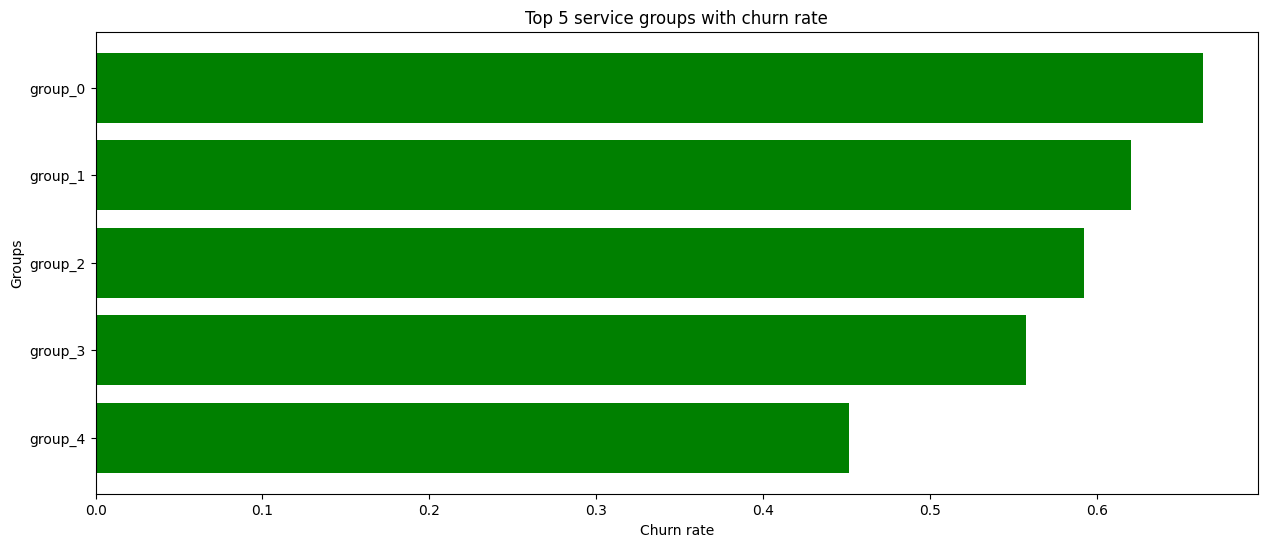

In [65]:
## Visualize top 5 churn driver
plt.figure(figsize=(15,6))
plt.barh(y=top_5_churn_driver.index, width=top_5_churn_driver['churn_rate'], color='green')
plt.title('Top 5 service groups with churn rate')
plt.xlabel('Churn rate')
plt.ylabel('Groups')
plt.show()

#### Comment:
The first group of service (**InternetService of type Fiber optic, PhoneService: yes, MultipleLines: yes, OnlineSecurity: No, OnlikeBackup: No, DeviceProtection: No, TechSupport: No, StreamingTV: yes, and StreamingMovies: yes**) is the highest churn driver.

### 3. Is churn driven more by price, service quality(online security), or contract type?

In [70]:
## Churn by monthly price
df['ChargeBand'] = pd.qcut(df['MonthlyCharges'],4)

df.groupby(by='ChargeBand', observed=False)['Churn'].mean().round(4)

ChargeBand
(18.249, 35.55]    0.1133
(35.55, 70.35]     0.2457
(70.35, 89.85]     0.3755
(89.85, 118.75]    0.3290
Name: Churn, dtype: float64

In [71]:
## Spread
max_churn = 0.3755
min_churn = 0.1133
spread = max_churn-min_churn
spread

0.2622

In [72]:
## Churn by contract type
df.groupby(by='Contract', observed=False)['Churn'].mean().round(4)

Contract
Month-to-month    0.4268
One year          0.1132
Two year          0.0285
Name: Churn, dtype: float64

In [73]:
## Spread
max_churn = 0.4268
min_churn = 0.0285
spread = max_churn-min_churn
spread

0.3983

In [74]:
## Churn by OnlineSecurity
df.groupby(by='OnlineSecurity', observed=False)['Churn'].mean().round(4)

OnlineSecurity
0    0.3136
1    0.1463
Name: Churn, dtype: float64

In [75]:
## Spread
max_churn = 0.3136
min_churn = 0.1463
spread = max_churn-min_churn
spread

0.16729999999999998

#### Comment:
The above analysis shows that contract type has more probability spread of churn. This indicates that it drives the churn more.

### 4. Do customers with no tech support churn faster?

In [76]:
tech_support_churn = df.groupby('TechSupport')['Churn'].mean()
tech_support_churn

TechSupport
0    0.312212
1    0.151917
Name: Churn, dtype: float64

In [78]:
risk_ratio = (
    tech_support_churn[0] /
    tech_support_churn[1]
)

risk_ratio

np.float64(2.055141425959923)

#### Comment:
The ratio > 1 → churn risk increases without tech support

### 5. What are the top 5 churn drivers?

In [79]:
driver_summary = []

for col in categorical_cols:
    churn_diff = (
        df.groupby(col)['Churn'].mean().max() -
        df.groupby(col)['Churn'].mean().min()
    )
    
    driver_summary.append({
        'Feature': col,
        'Churn_Impact': churn_diff,
        'Customer_Coverage': df[col].value_counts().iloc[0]
    })

driver_df = pd.DataFrame(driver_summary)
driver_df.sort_values(by='Churn_Impact', ascending=False)


,Feature,Churn_Impact,Customer_Coverage
0,Contract,0.398243,3871
1,InternetService,0.344703,3090
2,PaymentMethod,0.300400,2361
5,OnlineSecurity,0.167306,5012
8,TechSupport,0.160294,4987
6,OnlineBackup,0.076408,4601
7,DeviceProtection,0.061611,4611
9,StreamingTV,0.057488,4325
10,StreamingMovies,0.054770,4298
4,MultipleLines,0.036235,4060


## Feature Importance using ML

In [82]:
## Load the cleaned data
df = pd.read_csv("../data/processed/cleaned_telco_customer_churn.csv")

print(df.shape)
df.head()

(7021, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

model_df = df.copy()

for col in model_df.select_dtypes('object').columns:
    model_df[col] = LabelEncoder().fit_transform(model_df[col])

model_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [84]:
## Train the model

X = model_df.drop('Churn', axis=1)
y = model_df['Churn']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [85]:
## Find the feature importance

feature_importance = (
    pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
)

feature_importance.head(10)

,Feature,Importance
18,TotalCharges,0.189463
17,MonthlyCharges,0.182668
4,tenure,0.159604
14,Contract,0.079234
16,PaymentMethod,0.050816
8,OnlineSecurity,0.047471
11,TechSupport,0.040558
0,gender,0.027325
7,InternetService,0.027241
9,OnlineBackup,0.026737


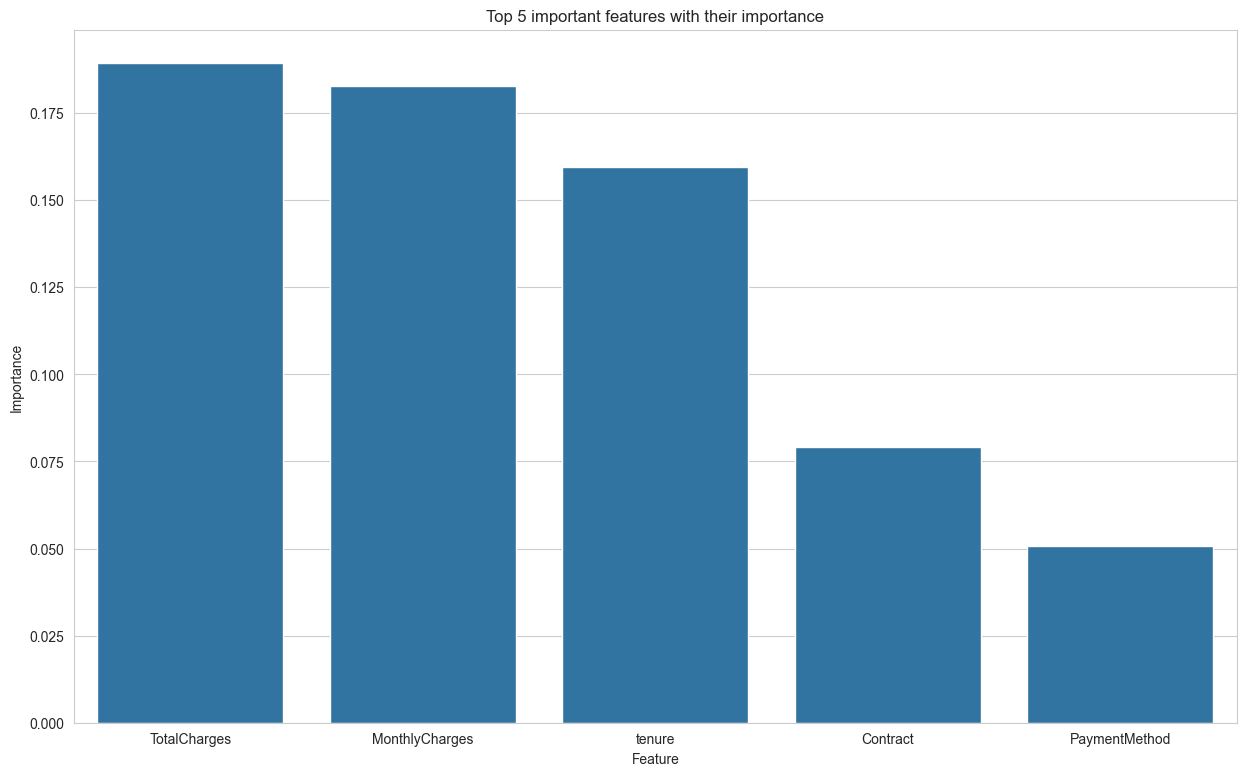

In [87]:
## Visualize top 5 important feature
plt.figure(figsize=(15,9))
sns.set_style('whitegrid')
sns.barplot(data=feature_importance.head(5), x='Feature', y='Importance')
plt.title("Top 5 important features with their importance")
plt.show()

#### Comment:
Top 5 important features which influences the churn are **"TotalCharges", "MonthlyCharges", "tenure", "Contract", "PaymentMethod"**

---
### 👨‍💻 Author Information
**Name:** [Amaresh Maity]  
**Date:** 2026-01-09  
**Role:** [Data Scientist | AI Engineer]



#### Let's Connect!

If you have questions about this analysis or would like to collaborate, feel free to reach out:

* **LinkedIn:** [LinkedIn](https://www.linkedin.com/in/amareshmaity/)
* **GitHub:** [@amareshmaity](https://github.com/amareshmaity)
* **Email:** [contacttoamaresh@gmail.com](mailto:contacttoamaresh@gmail.com)